In [47]:
import torch

from pathlib import Path
import random
import matplotlib.pyplot as plt
from PIL import Image
import numpy as np

from SegModel import UNet

import albumentations as A
from albumentations.pytorch.transforms import ToTensorV2

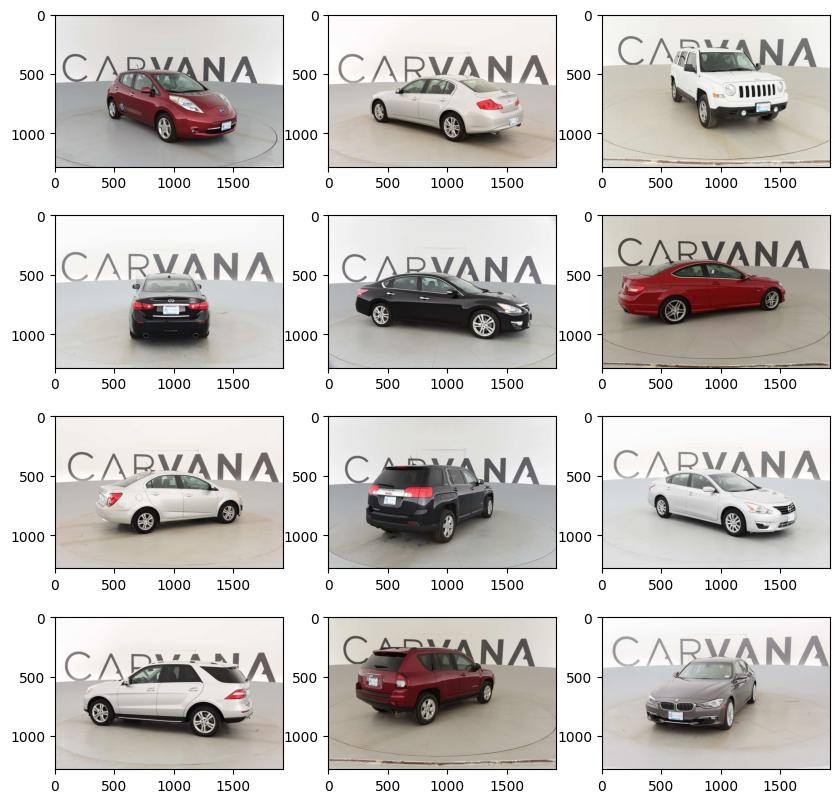

In [48]:
# -- TESTING -- (Total Images in this dir are 100,065) 
TESTING_DATASET_DIR = Path('/home/onkar/DATASET/carvana-image-masking-challenge/test/test')

selected_images = []
all_images = list(TESTING_DATASET_DIR.glob('*.jpg'))

if len(all_images) >= 12:
    selected_images.extend(random.sample(all_images, 12))
    #print(f'Selected Images :\n{selected_images}')
else:
    print('Not enough images in the directory to select 10 at random')

fig, axes = plt.subplots(4, 3, figsize=(10, 10))
count = 0
for i in range(4):
    for j in range(3):
        image = Image.open(selected_images[count])
        axes[i][j].imshow(image)
        count += 1
plt.show()

=> Loading Checkpoint
Image name : 41ccca311db8_15.jpg
Image name : 7b71fe5fcf7e_07.jpg
Image name : e9a3903879ea_16.jpg
Image name : 47fc944b2911_09.jpg
Image name : c4a97d02e2d1_14.jpg
Image name : 43d9f0b90061_12.jpg
Image name : e0f5eac88801_12.jpg
Image name : 6401e20b9424_11.jpg
Image name : 9b5ce8289162_15.jpg
Image name : a9f81ac6922a_06.jpg
Image name : 1722d4174f96_11.jpg
Image name : d7e659e516d2_02.jpg


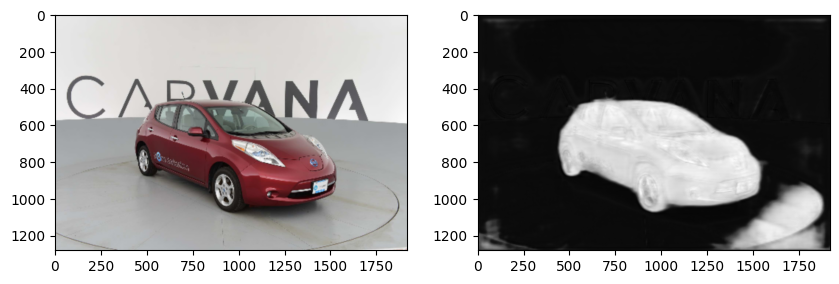

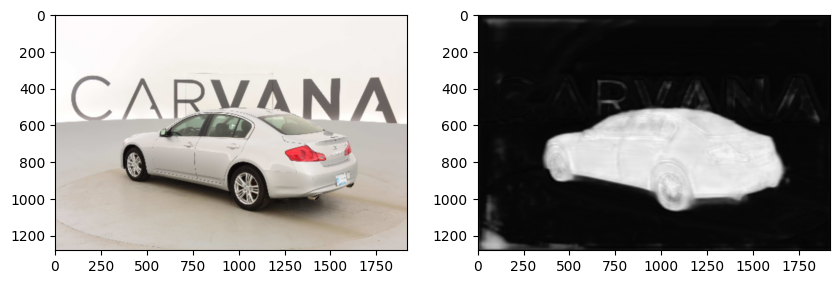

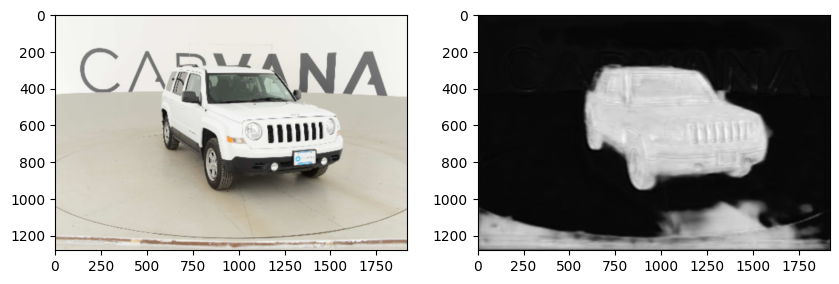

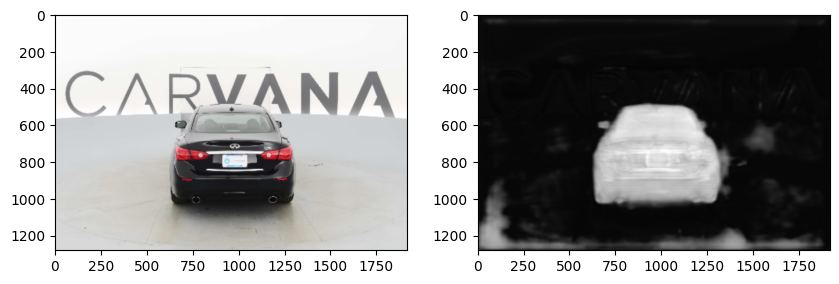

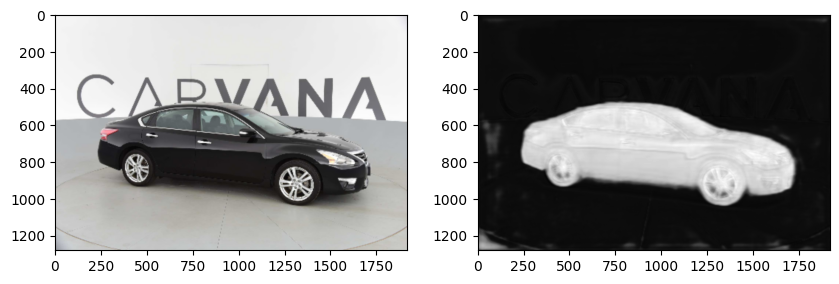

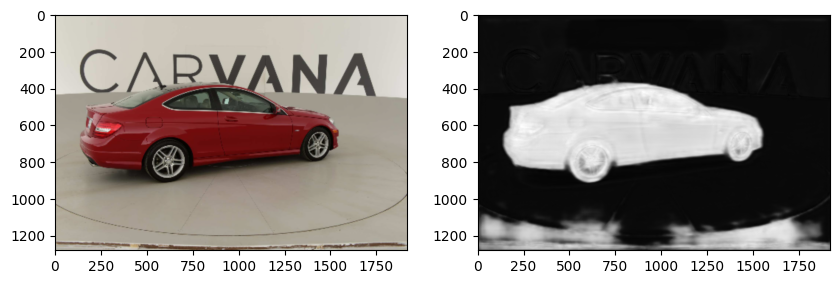

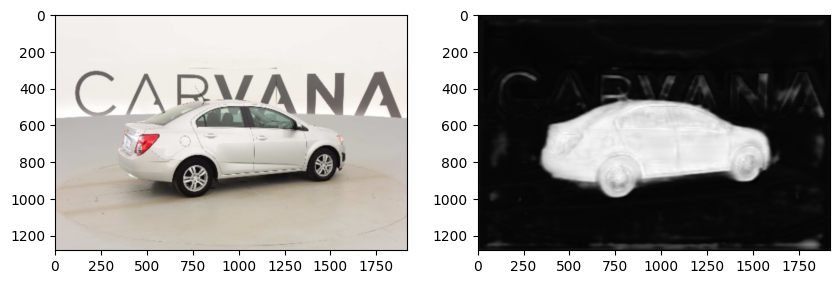

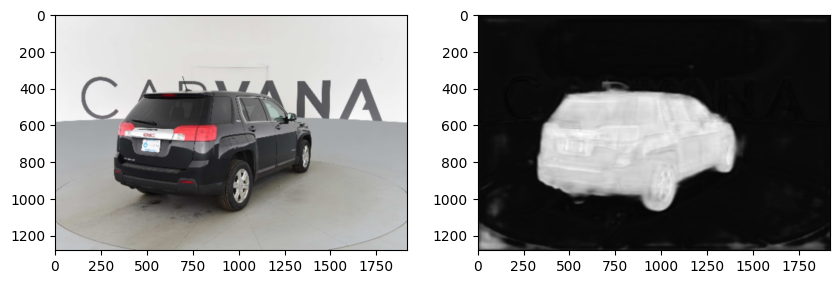

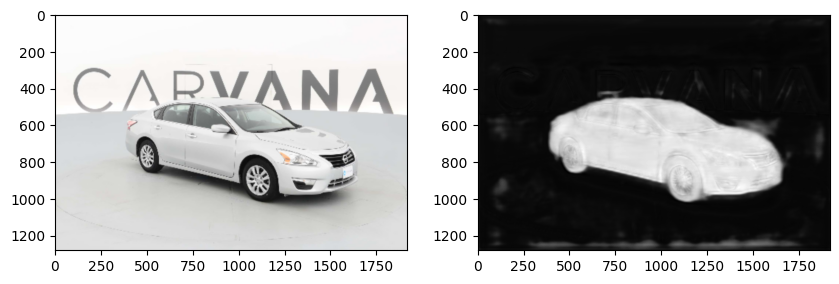

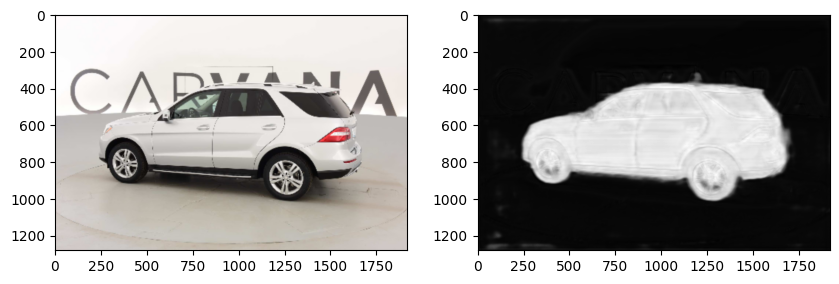

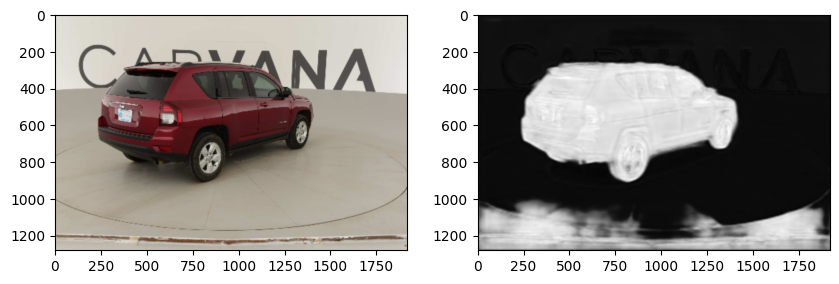

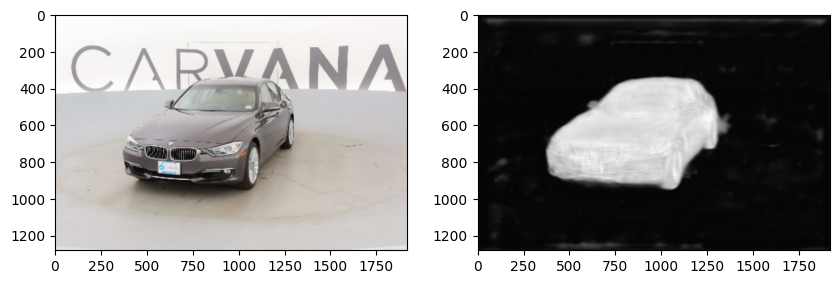

In [49]:
# -- Load model from the checkpoint -- 
DEVICE = "cuda" if torch.cuda.is_available() else "cpu"

model = UNet().to(device=DEVICE)
checkpoint=torch.load('checkpoints/my_checkpoint.pth')

print('=> Loading Checkpoint')
model.load_state_dict(checkpoint['state_dict'])

for img in selected_images:
    image_name = img.name
    print(f'Image name : {image_name}')
    image = Image.open(img)
    image_np = np.array(image).astype(np.float32)
    # print(f'Image size : {image_np.shape}')


    transform = A.Compose([
        A.Resize(height=image_np.shape[0]//4, width=image_np.shape[1]//4),
        ToTensorV2(transpose_mask=True)
    ])

    transformed = transform(image=image_np)
    resized_image = transformed['image']



    image = resized_image.unsqueeze(0).to(device=DEVICE)

    with torch.no_grad():
        predicated_mask = model(image)

    fig, axes = plt.subplots(1, 2, figsize=(10, 10))

    image = image[0].cpu().detach()
    if image.max() > 1.0:
        image = image/image.max() # Normalize to [0, 1]
    image = image.numpy().transpose(1, 2, 0)

    pred_mask = predicated_mask[0].cpu().detach()
    if pred_mask.max() > 1.0:
        pred_mask = pred_mask/pred_mask.max()
    pred_mask = pred_mask.numpy().transpose(1, 2, 0)

    transform = A.Resize(height=image_np.shape[0], width=image_np.shape[1])
    transformed = transform(image=image, mask=pred_mask)
    image = transformed['image']
    pred_mask = transformed['mask']

    axes[0].imshow(image)
    axes[1].imshow(pred_mask, cmap='gray')
    # /home/onkar/DATASET/carvana-image-masking-challenge/test/pred
    # plt.savefig('/mnt/data/path_to_file.jpg')
    

plt.show()
